<a href="https://colab.research.google.com/github/shahid-ikbal/Monsoon-Analysis/blob/main/TWS_Grace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geemap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.4 MB/s eta 0:00:00


In [2]:
import ee
import geemap

In [5]:
ee.Authenticate()
ee.Initialize(project='ee-shahidiqbal')

In [6]:
Map=geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

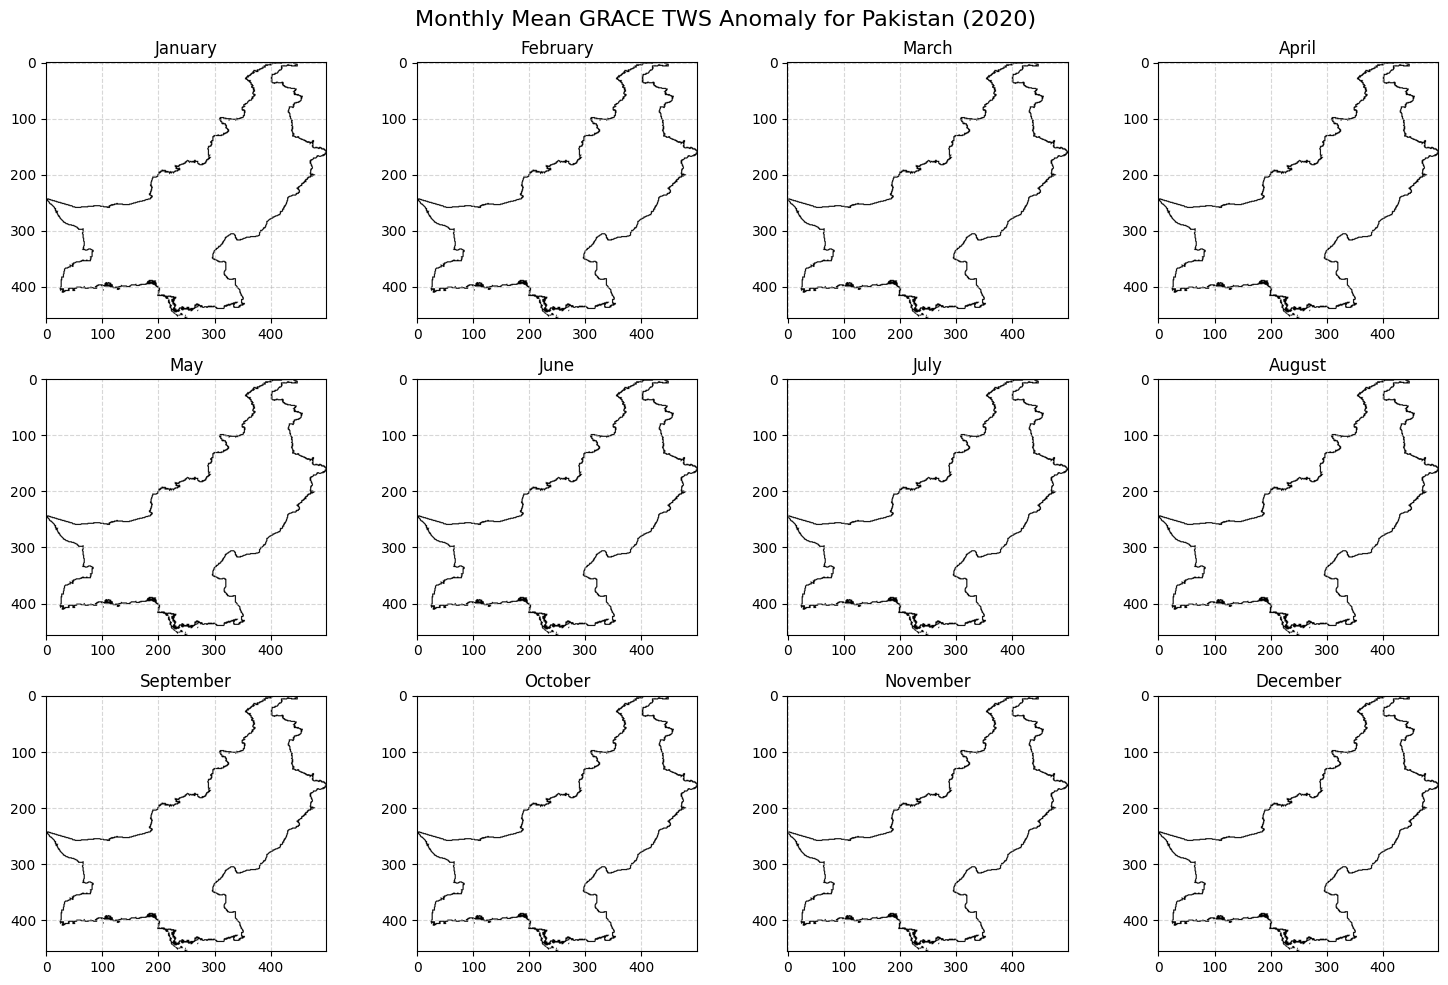

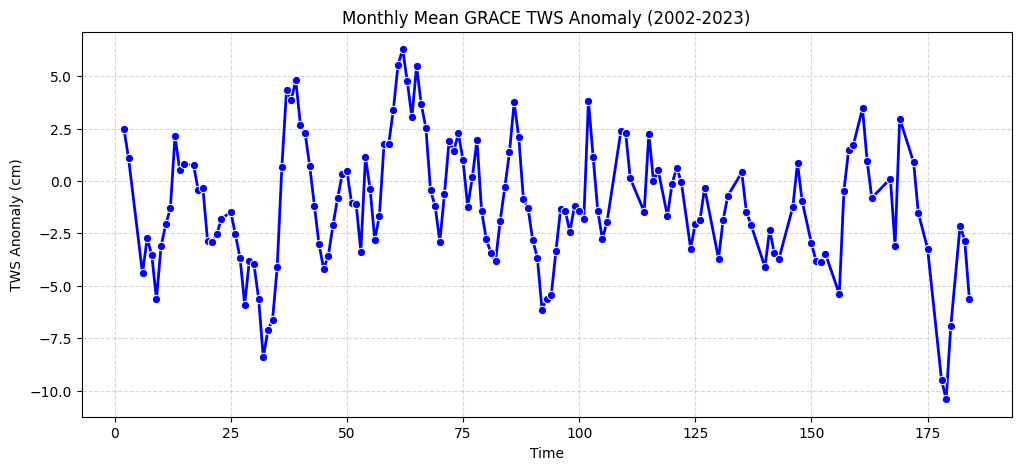

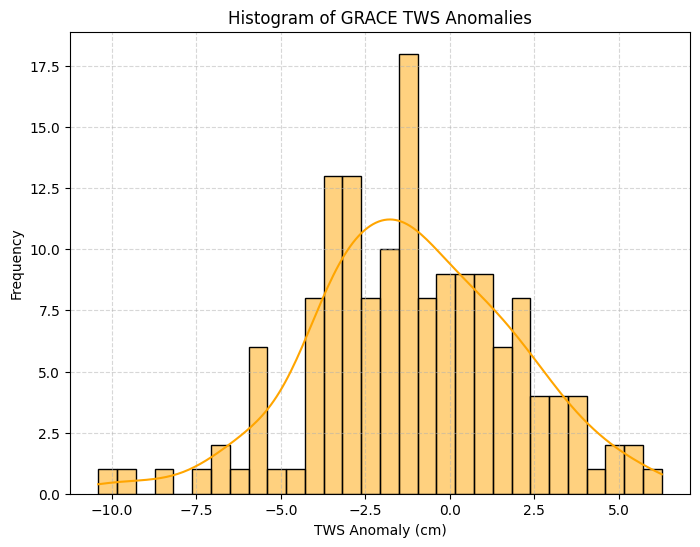

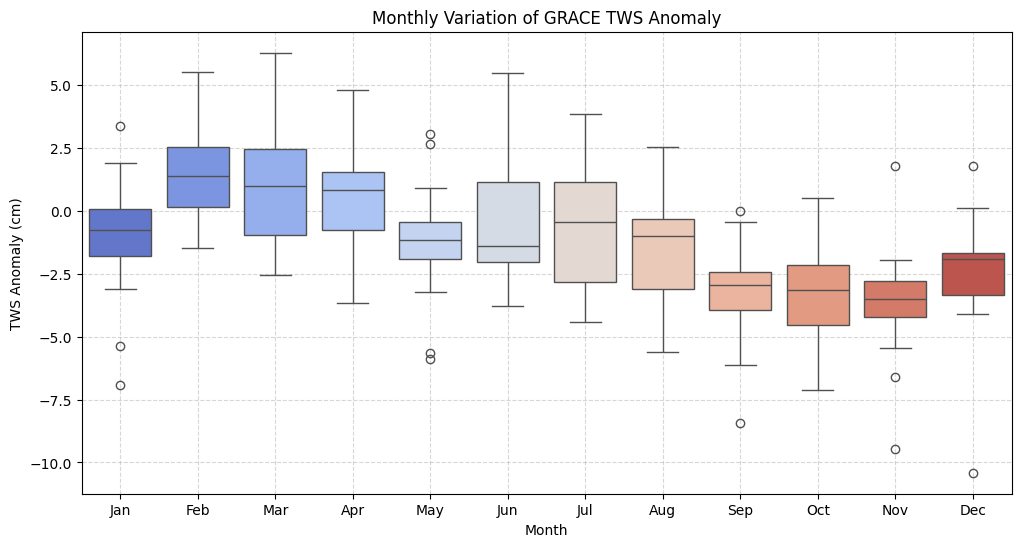

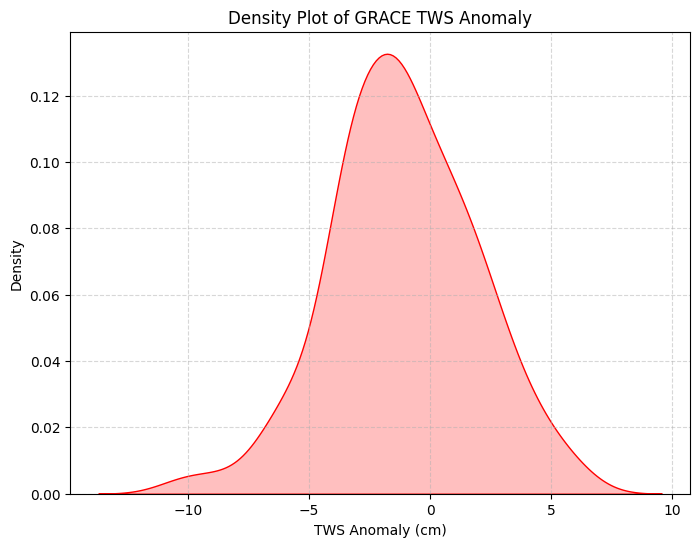

In [11]:
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np
import calendar
import requests
from io import BytesIO
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Initialize the Earth Engine API
ee.Initialize()

# Define the region of interest (Pakistan boundary)
pakistan = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Pakistan'))

# Define the date range for GRACE data
start_date = '2002-01-01'
end_date = '2023-12-31'

# Load GRACE Total Water Storage Anomaly dataset
grace = ee.ImageCollection("NASA/GRACE/MASS_GRIDS/MASCON_CRI")

# Filter GRACE data for Pakistan and time range
grace_filtered = grace.filterBounds(pakistan).filterDate(start_date, end_date)

# Compute Mean TWS Anomaly (Select 'lwe_thickness' Band)
grace_mean = grace_filtered.select('lwe_thickness').mean().clip(pakistan)

# Visualization Parameters for GRACE TWS
vis_params = {
    "min": -50,
    "max": 50,
    "palette": ["red", "yellow", "green", "blue"]
}

# Create an interactive map using geemap
Map = geemap.Map(center=[30.3753, 69.3451], zoom=5)
Map.addLayer(grace_mean, vis_params, "GRACE TWS Anomaly (2002-2023)")
Map.addLayer(pakistan, {}, "Pakistan Boundary")
Map  # This displays the interactive map

# -----------------------------
# Create Monthly Mean TWS Anomaly Maps
# -----------------------------
year = 2020
monthly_urls = []
months = range(1, 13)

for month in months:
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')

    # Filter the collection for the specific month and year
    monthly_collection = grace_filtered.filterDate(start, end)

    # Check if the collection is empty for this month
    if monthly_collection.size().getInfo() > 0:
        # If not empty, calculate the mean and select the band
        monthly = monthly_collection.mean().select('lwe_thickness').clip(pakistan)
    else:
        # If empty, create an empty image with the desired band
        monthly = ee.Image().rename(['lwe_thickness']).clip(pakistan)
        # or handle it differently, e.g., skip this month or use a placeholder value

    boundary = ee.Image().byte().paint(featureCollection=pakistan, color=0, width=2)

    monthly_vis = monthly.visualize(**vis_params)
    boundary_vis = boundary.visualize(**{'palette': ['black'], 'opacity': 1})
    combined = monthly_vis.blend(boundary_vis)

    thumb_params = {'dimensions': 500, 'region': pakistan.geometry().bounds().getInfo()}
    url = combined.getThumbURL(thumb_params)
    monthly_urls.append(url)

# Plot Monthly TWS Anomaly Maps
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle(f'Monthly Mean GRACE TWS Anomaly for Pakistan ({year})', fontsize=16)

for idx, url in enumerate(monthly_urls):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    ax = axs[idx // 4, idx % 4]
    ax.imshow(img)
    ax.set_title(calendar.month_name[idx + 1])
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# -----------------------------
# Compute Monthly Mean TWS Anomaly
# -----------------------------
monthly_means = []
years = list(range(2002, 2024))
for year in years:
    for month in months:
        start = ee.Date.fromYMD(year, month, 1)
        end = start.advance(1, 'month')

        filtered_collection = grace_filtered.filterDate(start, end).select('lwe_thickness')

        if filtered_collection.size().getInfo() > 0:
            monthly = filtered_collection.mean().clip(pakistan)
            mean_value = monthly.reduceRegion(ee.Reducer.mean(), pakistan, 1000).getInfo()
            monthly_means.append([year, month, mean_value['lwe_thickness'] if mean_value else None])
        else:
            monthly_means.append([year, month, np.nan])

# Convert to DataFrame
df = pd.DataFrame(monthly_means, columns=['Year', 'Month', 'TWS_Anomaly'])
df.dropna(inplace=True)

# Time Series Plot
plt.figure(figsize=(12, 5))
sns.lineplot(x=df.index, y=df['TWS_Anomaly'], marker='o', color='b', linewidth=2)
plt.title('Monthly Mean GRACE TWS Anomaly (2002-2023)')
plt.xlabel('Time')
plt.ylabel('TWS Anomaly (cm)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Histogram of TWS Anomalies
plt.figure(figsize=(8, 6))
sns.histplot(df['TWS_Anomaly'], bins=30, kde=True, color='orange')
plt.title('Histogram of GRACE TWS Anomalies')
plt.xlabel('TWS Anomaly (cm)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Box Plot for Monthly TWS Variation
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Month'], y=df['TWS_Anomaly'], palette='coolwarm')
plt.xticks(ticks=np.arange(12), labels=[calendar.month_abbr[i] for i in range(1, 13)])
plt.title('Monthly Variation of GRACE TWS Anomaly')
plt.xlabel('Month')
plt.ylabel('TWS Anomaly (cm)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# KDE Plot
plt.figure(figsize=(8, 6))
sns.kdeplot(df['TWS_Anomaly'], shade=True, color='red')
plt.title('Density Plot of GRACE TWS Anomaly')
plt.xlabel('TWS Anomaly (cm)')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
